#Step 1: Pip Install and Import Libraries

##1a) Import Data Manipulation Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Install TALIB---------------------------------------------------------
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install

!pip install Ta-Lib
import talib as ta

#Install Pyfolio------------------------------------------------------
!pip install pyfolio
import pyfolio as pf

#Install Yahoo Finance------------------------------------------------
!pip install yfinance
import yfinance as yf

<ipython-input-1-40d2ad1fe28d>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


--2023-07-21 14:47:58--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-21 14:47:58--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-21 14:47:58--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixna

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(




---



#Step 2: Import Dataset & Plot

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600
...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200


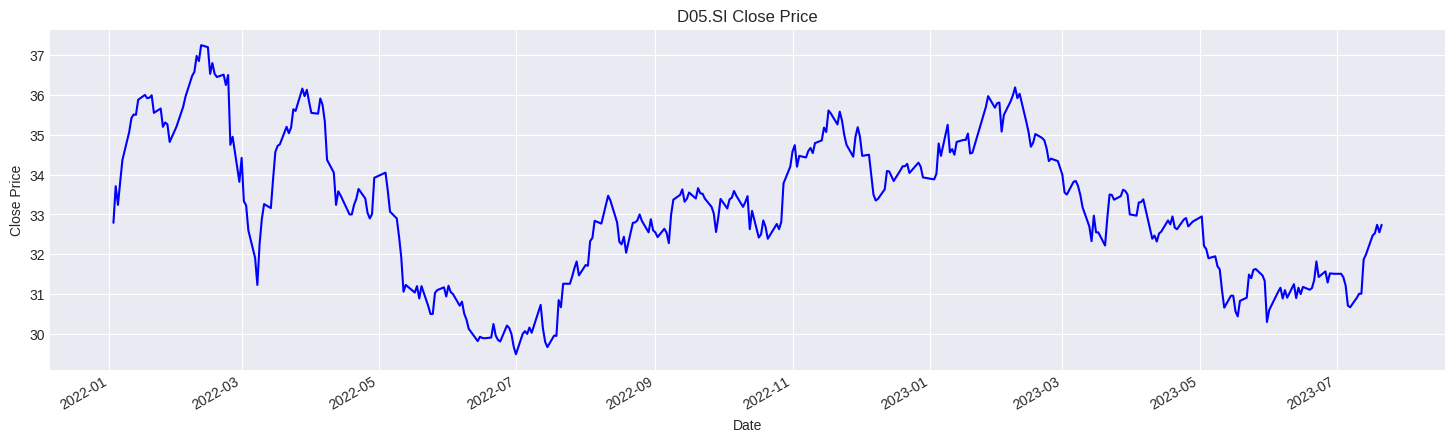

In [2]:
ticker = 'D05.SI'
data = yf.download(ticker,start='2022-01-01')
display(data)

#we only want the Close price
#data = pd.DataFrame(data['Close'])
#display(data)

#Plot---------------------------------------
data.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()



---



#Step 3: Create a Function to Define Features and Target

Mission:
- we are trying to define X to predict y
- y is the Stock Close Price
- X will contain arbitary features defined by us that we believe can be used as indicators to predict y  
- later on, we will use X and y to train the Logistic Regression Model to assist with the prediction

In [3]:
def get_target_features(data):

    # -------------------------------------------------------------
    # Define Features (X)
    #Volatility
    #(we use the pct_change() to get the Volatility)
    data['PCT_CHANGE'] = data['Close'].pct_change()
    data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100

    #Correlation
    #(we use the SMA to get the CORR)
    data['SMA'] = ta.SMA(data['Close'],14)
    data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)

    #RSI (unused)
    data['RSI'] = ta.RSI(data['Close'].values, timeperiod=14)

    #ADX (unused)
    data['ADX'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=14)


    # ------------------------------------------------------------
    # Define Target (y)
    data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)

    # Create the signal column
    data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)

    data = data.dropna()

    return data['Actual_Signal'], data[['VOLATILITY', 'CORR', 'RSI', 'ADX']]


##Features, X: Volatility & Correlation

###1) PCT_CHANGE(): (we use it to get Volatility)
- (current value — previous value) / previous value * 100
- Basically, it tells us how today is performing compared to yesterday.
- "if u had bought YESETERDAY, this would have been your returns TODAY..."

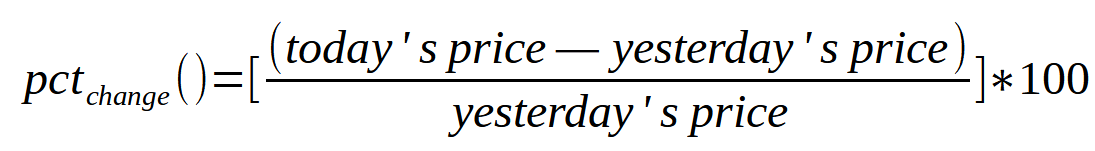

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE
Date,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263
...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456


<Axes: xlabel='Date'>

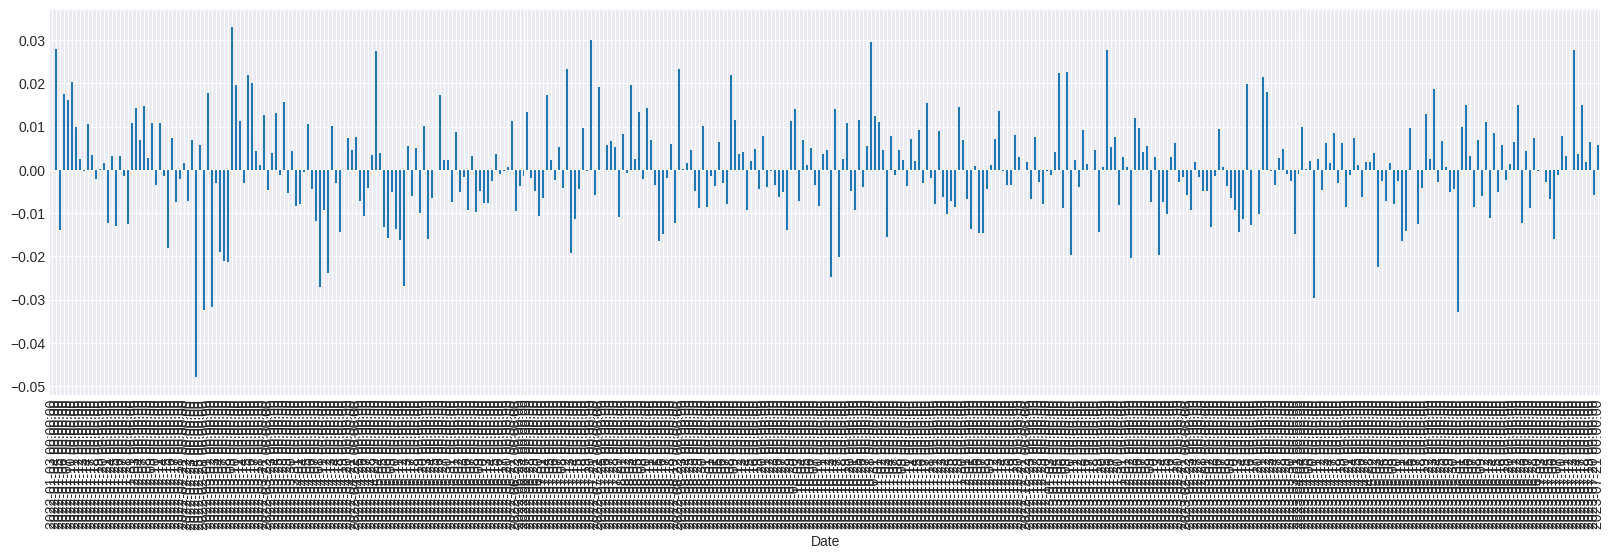

In [4]:
data['PCT_CHANGE'] = data['Close'].pct_change()
display(data)
#notice a new column "pct_change" has been created

data['PCT_CHANGE'].plot(kind='bar', figsize=(20,5))



---



###2) Volatility

- Volatility is measured by the standard deviation of the asset over a given period of time.
- The higher the standard deviation, the higher the volatility.

- In general, a volatility of 10% or less is considered to be low
- A volatility of 20% or more is considered to be high.

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY
Date,,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN,NaN
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057,NaN
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942,NaN
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449,NaN
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263,NaN
...,...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005,1.061423
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848,1.014116
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456,1.011324


<Axes: xlabel='Date'>

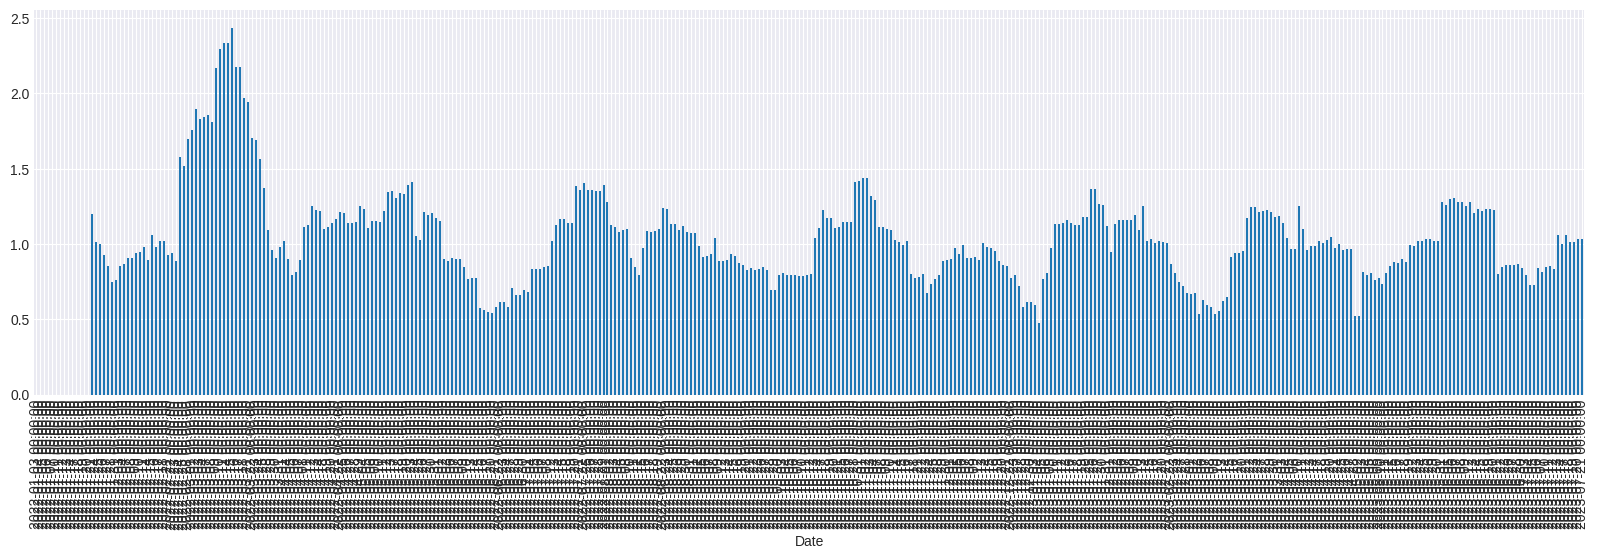

In [5]:
data['VOLATILITY'] = data.rolling(14)['PCT_CHANGE'].std()*100
display(data)
#notice a new column "volatility" has been created

data['VOLATILITY'].plot(kind='bar', figsize=(20,5))
#perhaps we should only buy when there's great volatility?



---



###3) SMA (we use the SMA to get the Corr)

How does SMA work?

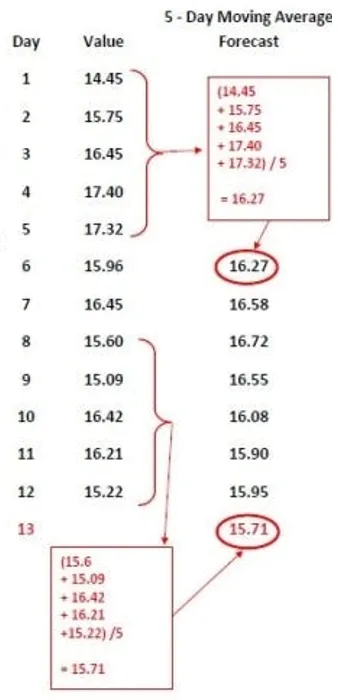

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA
Date,,,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN,NaN,NaN
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057,NaN,NaN
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942,NaN,NaN
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449,NaN,NaN
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005,1.061423,31.364286
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848,1.014116,31.452857
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456,1.011324,31.540000


<Axes: xlabel='Date'>

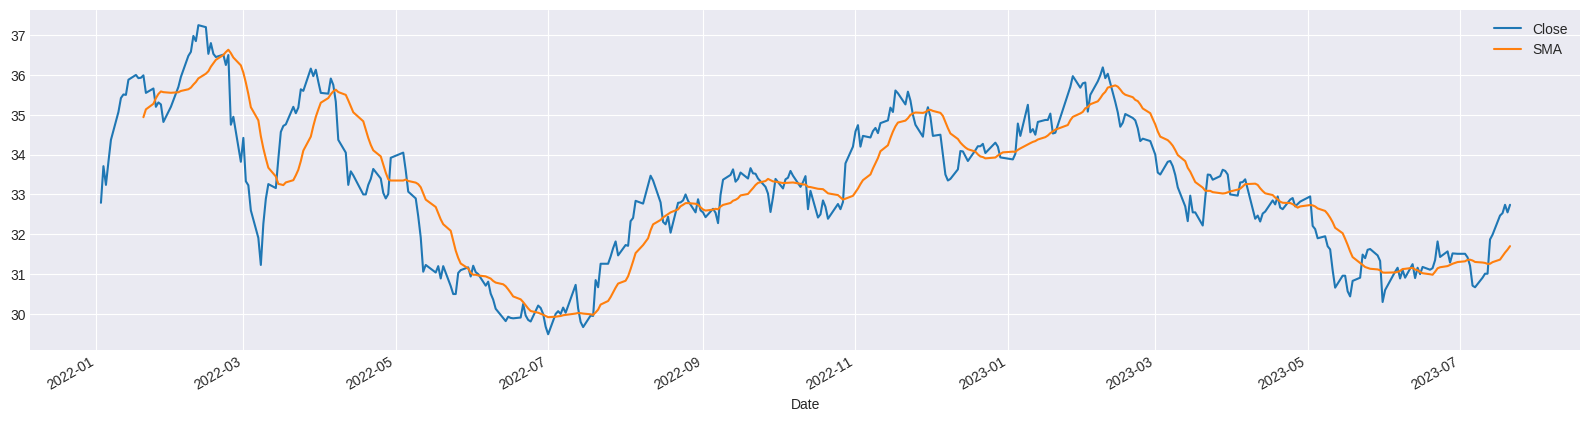

In [6]:
data['SMA'] = ta.SMA(data['Close'],14)
display(data)


data[['Close', 'SMA']].plot(figsize=(20,5))



---



###4) Correlation

- Correlation coefficient is between -1 and 1.
- 1 indicates a perfect positive correlation
- -1 indicates a perfect negative correlation
- 0 indicates no correlation.

- The corr function calculates the correlation between 'Close' and 'SMA' over a window of 14 days.

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR
Date,,,,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN,NaN,NaN,NaN
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057,NaN,NaN,NaN
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942,NaN,NaN,NaN
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449,NaN,NaN,NaN
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005,1.061423,31.364286,0.151744
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848,1.014116,31.452857,0.464025
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456,1.011324,31.540000,0.662674


<Axes: xlabel='Date'>

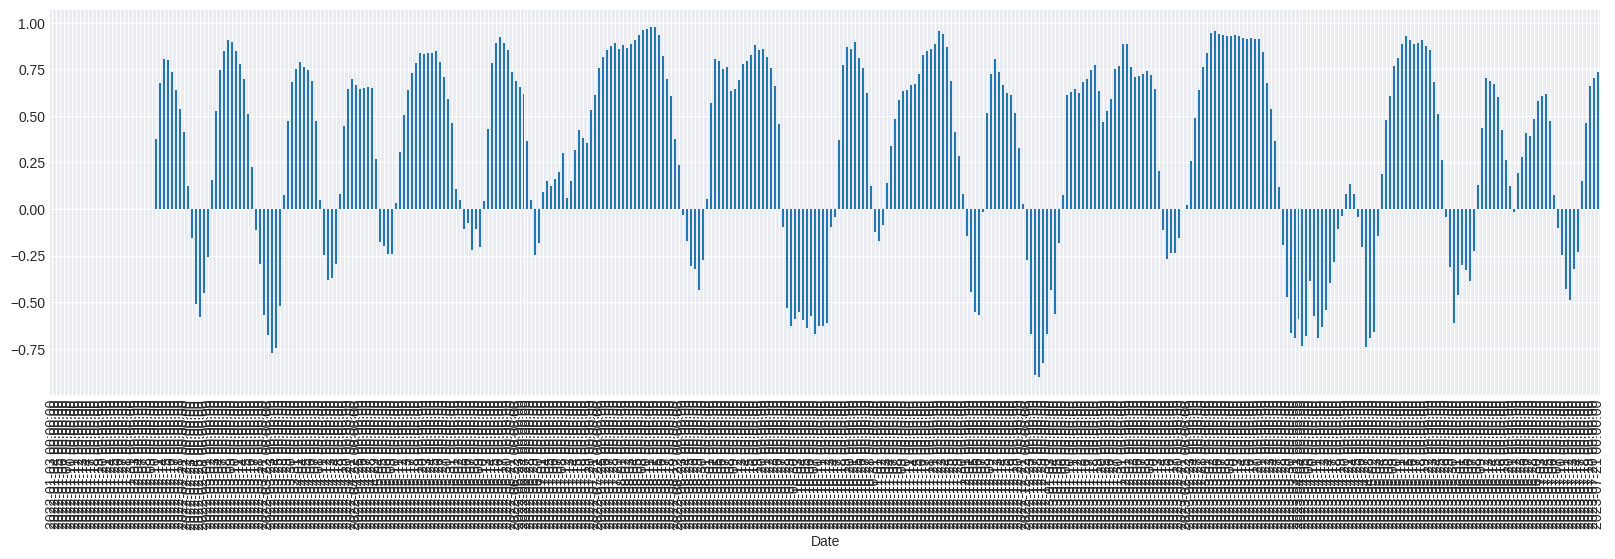

In [7]:
data['CORR'] = ta.CORREL(data['Close'], data['SMA'], 14)
display(data)

data['CORR'].plot(kind='bar', figsize=(20,5))

#SMA and the Close price is supposed to move together,
#but u can see that sometimes it doesn't.
#perhaps when there's -ve correlation, we shouldn't buy?



---



###5) RSI

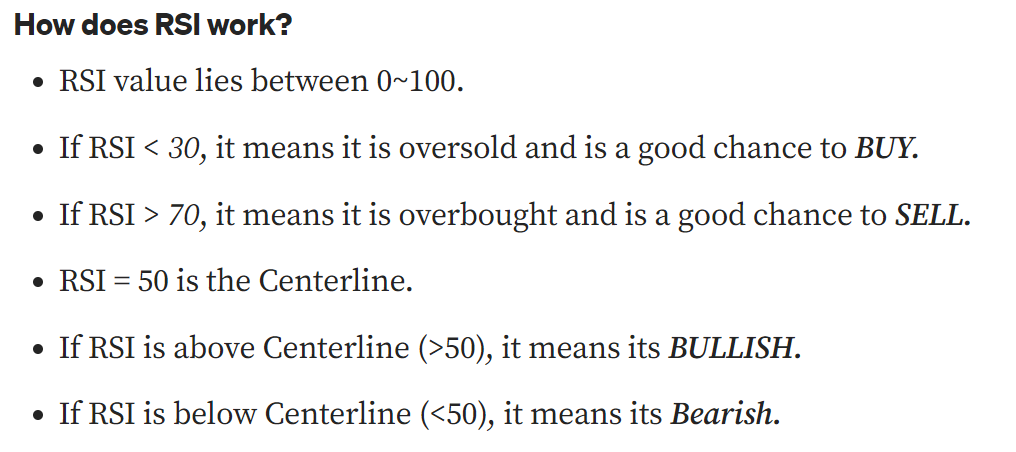

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI
Date,,,,,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN,NaN,NaN,NaN,NaN
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057,NaN,NaN,NaN,NaN
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942,NaN,NaN,NaN,NaN
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449,NaN,NaN,NaN,NaN
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005,1.061423,31.364286,0.151744,66.634666
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848,1.014116,31.452857,0.464025,67.240501
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456,1.011324,31.540000,0.662674,69.339056


<Axes: xlabel='Date'>

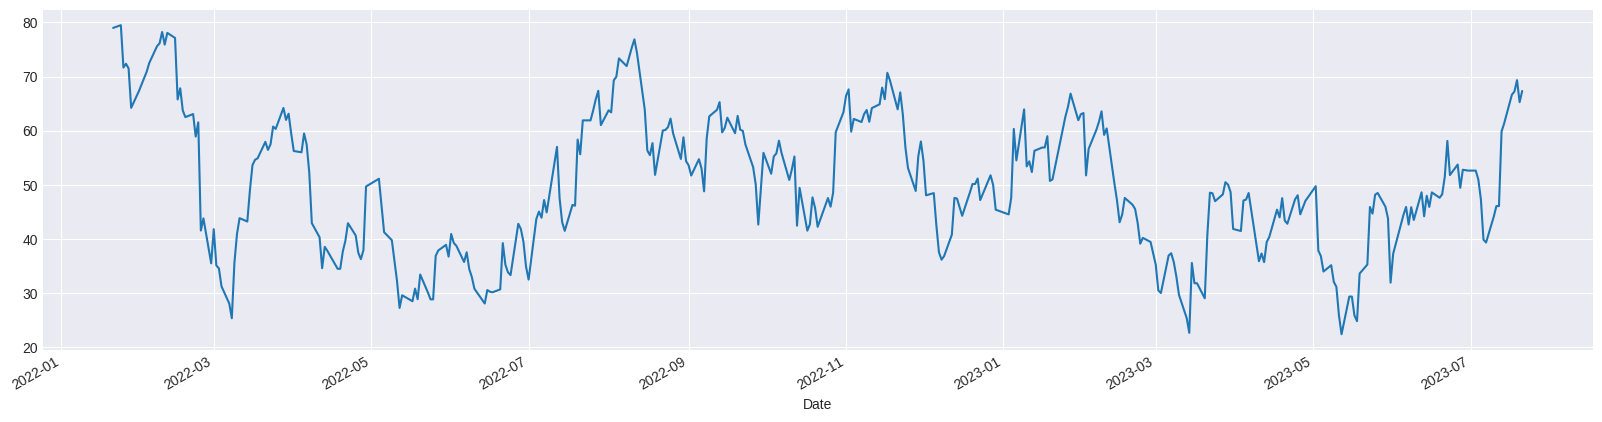

In [8]:
data['RSI'] = ta.RSI(data['Close'].values, timeperiod=14)
display(data)

data['RSI'].plot(figsize=(20,5))



---



###6) ADX

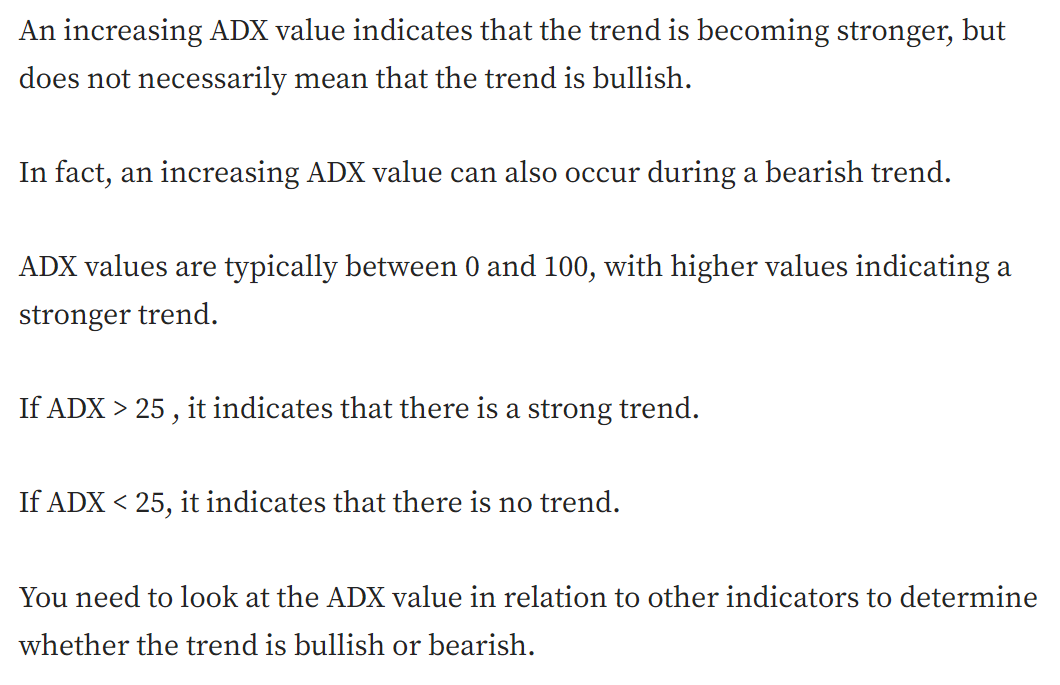

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX
Date,,,,,,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057,NaN,NaN,NaN,NaN,NaN
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942,NaN,NaN,NaN,NaN,NaN
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449,NaN,NaN,NaN,NaN,NaN
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005,1.061423,31.364286,0.151744,66.634666,16.255192
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848,1.014116,31.452857,0.464025,67.240501,18.030227
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456,1.011324,31.540000,0.662674,69.339056,19.946824


<Axes: xlabel='Date'>

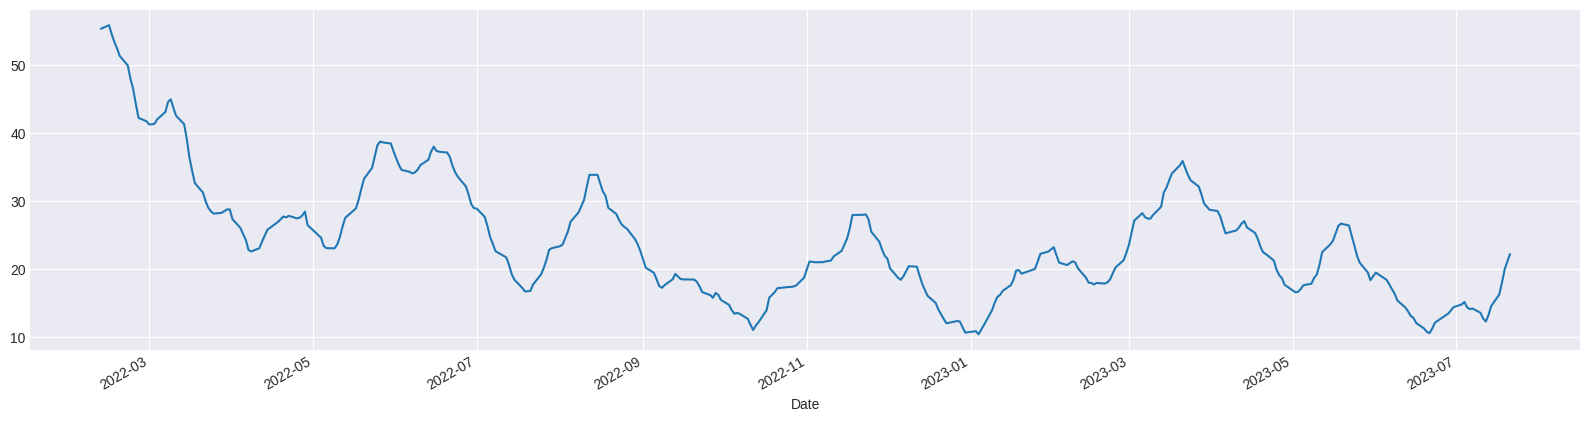

In [9]:
data['ADX'] = ta.ADX(data['High'].values, data['Low'].values, data['Open'].values, timeperiod=14)
display(data)

data['ADX'].plot(figsize=(20,5))



---



##Target, y: Returns for Tomorrow & Signal

###1) Returns 4 Tmrw

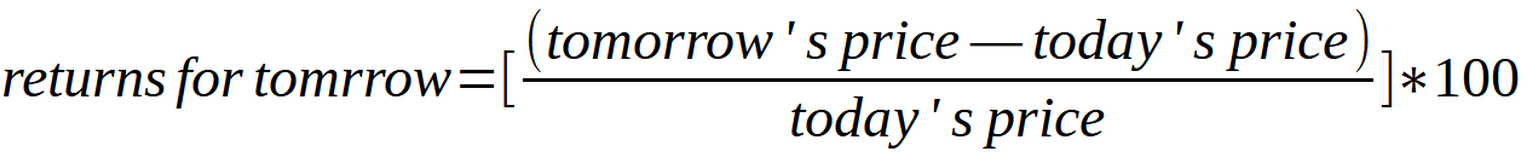

- "if you buy TODAY, this will be your returns for TOMORROW"
- we use the 'Returns 4 Tomorrow' to determine whether is GOOD or NO GOOD.
- If the Returns is positive, its GOOD.
- If the Returns is Negative, its BAD.
- in other words, we are going to use the Returns as a labelled indicator to train the model (to predict whether to buy or not).


,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,Returns_4_Tmrw
Date,,,,,,,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN,NaN,NaN,NaN,NaN,NaN,0.028057
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057,NaN,NaN,NaN,NaN,NaN,-0.013942
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942,NaN,NaN,NaN,NaN,NaN,0.017449
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449,NaN,NaN,NaN,NaN,NaN,0.016263
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263,NaN,NaN,NaN,NaN,NaN,0.020367
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005,1.061423,31.364286,0.151744,66.634666,16.255192,0.001848
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848,1.014116,31.452857,0.464025,67.240501,18.030227,0.006456
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456,1.011324,31.540000,0.662674,69.339056,19.946824,-0.005803


<Axes: xlabel='Date'>

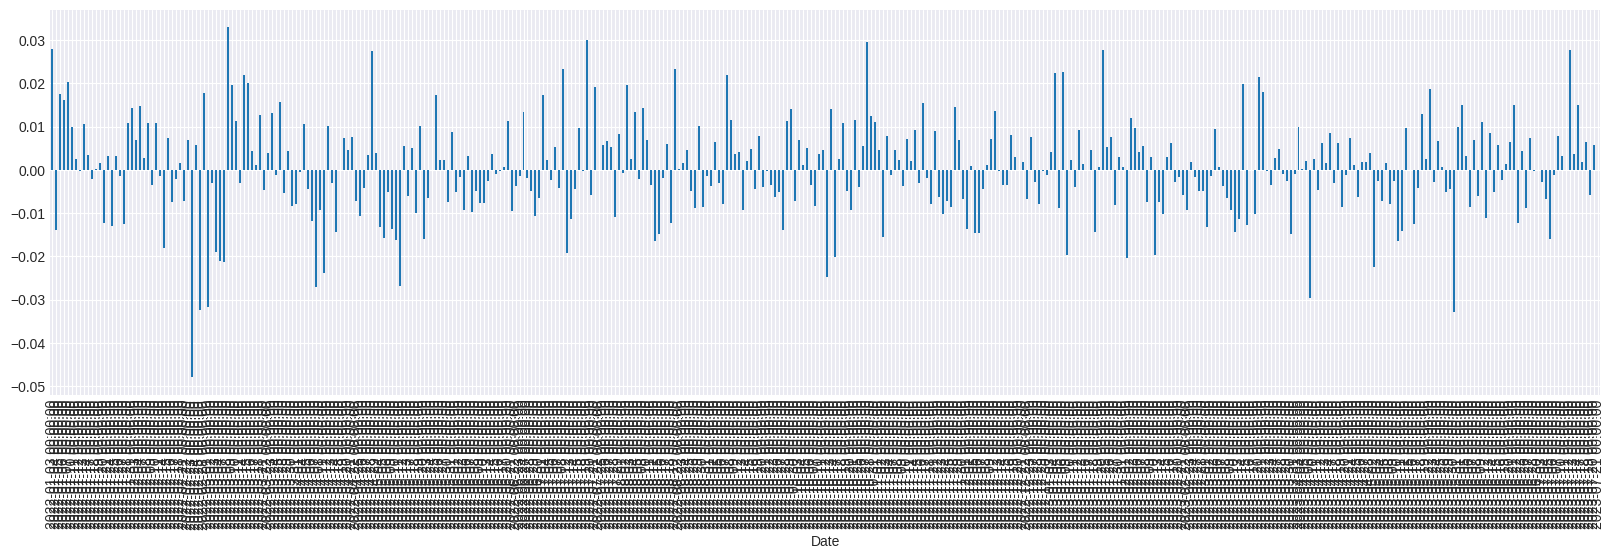

In [10]:
# Define Target (y)
data['Returns_4_Tmrw'] = data['Close'].pct_change().shift(-1)
display(data)
#notice a new column 'Returns_4_Tmrw' has been created

data['Returns_4_Tmrw'].plot(kind='bar', figsize=(20,5))



---



###2) Creating the Signal

##np.where()
- If data['Returns_4_Tmrw'] > 0, then Signal will turn 1, else 0.
- 1: Means GOOD = BUY.
- 0: Means BAD = Don't BUY.
- in other words, the Returns column is the "labelled data" used for training

In [11]:
data['Actual_Signal'] = np.where(data['Returns_4_Tmrw'] > 0, 1, 0)
display(data)

#notice a new column 'signal' has been created
#1 means BUY for that day
#0 means DON'T BUY for that day

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,Returns_4_Tmrw,Actual_Signal
Date,,,,,,,,,,,,,,
2022-01-03,32.799999,32.830002,32.720001,32.790001,30.540998,1610600,NaN,NaN,NaN,NaN,NaN,NaN,0.028057,1
2022-01-04,33.049999,33.779999,33.009998,33.709999,31.397896,5285200,0.028057,NaN,NaN,NaN,NaN,NaN,-0.013942,0
2022-01-05,33.799999,33.849998,33.070000,33.240002,30.960136,4654600,-0.013942,NaN,NaN,NaN,NaN,NaN,0.017449,1
2022-01-06,32.980000,33.820000,32.959999,33.820000,31.500351,4700100,0.017449,NaN,NaN,NaN,NaN,NaN,0.016263,1
2022-01-07,34.150002,34.369999,34.040001,34.369999,32.012627,5028600,0.016263,NaN,NaN,NaN,NaN,NaN,0.020367,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17,32.279999,32.500000,32.099998,32.470001,32.470001,3088700,0.015005,1.061423,31.364286,0.151744,66.634666,16.255192,0.001848,1
2023-07-18,32.500000,32.650002,32.450001,32.529999,32.529999,2582600,0.001848,1.014116,31.452857,0.464025,67.240501,18.030227,0.006456,1
2023-07-19,32.820000,32.849998,32.619999,32.740002,32.740002,2939200,0.006456,1.011324,31.540000,0.662674,69.339056,19.946824,-0.005803,0




---



#Step 4: Train Test Split

##4a) Display y and X

In [12]:
y, X = get_target_features(data)

In [13]:
y.head()

Date
2022-02-11    0
2022-02-14    0
2022-02-15    1
2022-02-16    0
2022-02-17    0
Name: Actual_Signal, dtype: int64

In [14]:
X.head()

,VOLATILITY,CORR,RSI,ADX
Date,,,,
2022-02-11,0.980410,0.678399,78.073189,55.404533
2022-02-14,0.893955,0.803478,77.138855,55.937374
2022-02-15,1.059925,0.797975,65.778730,54.618217
2022-02-16,0.979500,0.737916,67.834494,53.467050
2022-02-17,1.019415,0.641699,63.712685,52.524569


##4b) Split 80% for Training and 20% for Testing

In [15]:
split = int(0.8*len(X))
#80% of the total number of rows

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
#X[:split] means from row 0 to row number 'split'
#X[split:] means from row 'split' until the last row



---



#Step 5: Use StandardScaler() to Scale the X

##5a) Import the StandardScaler()

In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

##5b) Scale X_train and X_test

In [17]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**sc.fit_transform(X_train): **
- The scaling parameters are learned from the training data and are stored in the scaler object.

**sc.transform(X_test): **
- This method transforms the test data using the scaling parameters that were learned from the training data.
- The test data is not scaled again, because this would introduce noise into the data.

**In general, **
- Use **sc.fit_transform(X_train)** on the training data and then use **sc.transform(X_test)** on the test data.

- This will ensure that the training and test data are scaled in the same way and that the model makes accurate predictions on the test data.



---



#Step 6: Import Logistic Regression Model and Start Training

##6a) Importing and Training

In [18]:
model = LogisticRegression()
model = model.fit(X_train,y_train)

##6b) Predicting y_pred

In [19]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1])

##6c) Showing the Probabilities for 0 and 1

In [20]:
probability = model.predict_proba(X_test)
print(probability)

[[0.62104093 0.37895907]
 [0.5412001  0.4587999 ]
 [0.60154089 0.39845911]
 [0.64486215 0.35513785]
 [0.63491904 0.36508096]
 [0.61786985 0.38213015]
 [0.59610877 0.40389123]
 [0.58126153 0.41873847]
 [0.56152258 0.43847742]
 [0.53945557 0.46054443]
 [0.55627693 0.44372307]
 [0.5463758  0.4536242 ]
 [0.55788366 0.44211634]
 [0.55719047 0.44280953]
 [0.59074919 0.40925081]
 [0.71271932 0.28728068]
 [0.70294694 0.29705306]
 [0.58062387 0.41937613]
 [0.5672825  0.4327175 ]
 [0.54666152 0.45333848]
 [0.55525265 0.44474735]
 [0.54483204 0.45516796]
 [0.55803866 0.44196134]
 [0.53839549 0.46160451]
 [0.53481393 0.46518607]
 [0.53965755 0.46034245]
 [0.54732108 0.45267892]
 [0.54518216 0.45481784]
 [0.55947412 0.44052588]
 [0.53282874 0.46717126]
 [0.53547051 0.46452949]
 [0.52744853 0.47255147]
 [0.5270571  0.4729429 ]
 [0.52961248 0.47038752]
 [0.54302037 0.45697963]
 [0.55266921 0.44733079]
 [0.56106373 0.43893627]
 [0.46660593 0.53339407]
 [0.46779423 0.53220577]
 [0.45176332 0.54823668]




---



#Step 7: Confusion Matrix and Accuracy Metric

In [21]:
def get_metrics(y_test, predicted):
    confusion_matrix_data = metrics.confusion_matrix(y_test, predicted)
    # Plot the data

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, fmt="d",cmap='Blues', cbar=False, annot=True, ax=ax)

    # Set the axes labels and the title
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('Actual Labels', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14)
    ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
    ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

    # Display the plot
    plt.show()

    print('\n\n\n',metrics.classification_report(y_test, predicted))


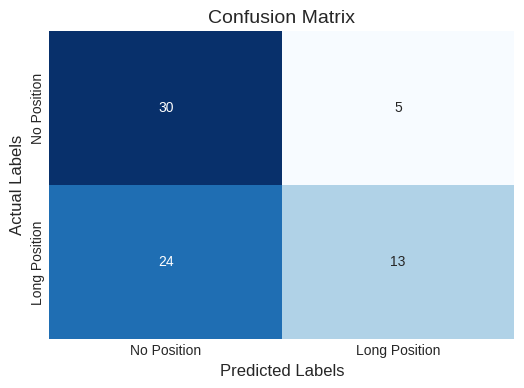




               precision    recall  f1-score   support

           0       0.56      0.86      0.67        35
           1       0.72      0.35      0.47        37

    accuracy                           0.60        72
   macro avg       0.64      0.60      0.57        72
weighted avg       0.64      0.60      0.57        72



In [22]:
get_metrics(y_test, y_pred)

In [23]:
#if the Accuracy (placed below the f1-score) is low... try
#1) putting in more metrics like SMA and Corr
#2) shortening the time period of testing
#3) change the ML model?



---



#Step 8: Backtesting Our Model

##8a) Obtaining our Backtest Data

[*********************100%***********************]  1 of 1 completed


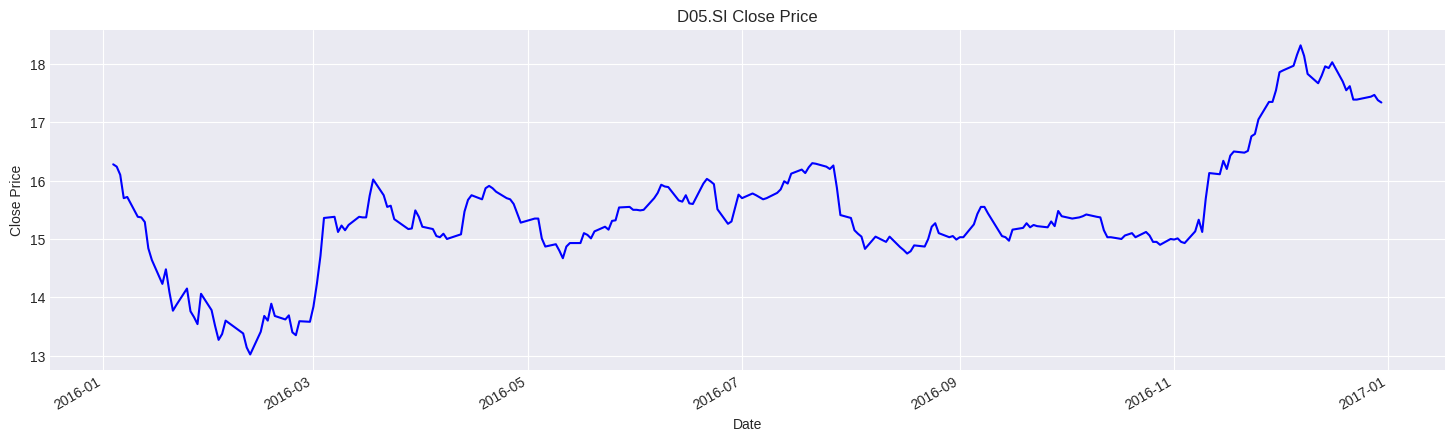

In [24]:
ticker = 'D05.SI'
df = yf.download(ticker,start='2016-01-01', end='2017-01-01')
#we change the dates
#and is no longer called "data" but "df"

#we only want the Close price
#df = pd.DataFrame(df['Close'])
#display(df)

#Plot---------------------------------------
df.Close.plot(figsize=(18,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title(f'{ticker} Close Price' )
plt.show()

##8b) Creating Volatility + Correlation + RSI + ADX Columns as Features

In [25]:
#Create Volatility-----------------------------------------------
df['PCT_CHANGE'] = df['Close'].pct_change()
df['VOLATILITY'] = df.rolling(14)['PCT_CHANGE'].std()*100

#Create Correlation----------------------------------------------
df['SMA'] = ta.SMA(df['Close'],14)
df['CORR'] = ta.CORREL(df['Close'], df['SMA'], 14)

#Create RSI------------------------------------------------------
df['RSI'] = ta.RSI(df['Close'].values, timeperiod=14)

#Create ADX------------------------------------------------------
df['ADX'] = ta.ADX(df['High'].values, df['Low'].values, df['Open'].values, timeperiod=14)

df = df.dropna()

#Create a temp_df to slice out only Volatility and Correlation
#temp_df = df[['VOLATILITY','CORR']]

display(df)

,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX
Date,,,,,,,,,,,,
2016-02-12,13.050000,13.140000,13.010000,13.020000,9.299974,9642300,-0.009132,1.908627,13.579286,0.805925,25.203148,54.944733
2016-02-15,13.140000,13.480000,13.110000,13.410000,9.578545,12306000,0.029954,2.097066,13.546429,0.799983,33.922545,53.226424
2016-02-16,13.400000,13.870000,13.320000,13.680000,9.771401,12601500,0.020134,2.096629,13.512857,0.604676,39.206348,50.463194
2016-02-17,13.800000,13.850000,13.530000,13.600000,9.714259,6574014,-0.005848,1.971203,13.501429,0.502829,38.230870,47.897338
2016-02-18,13.840000,13.980000,13.780000,13.890000,9.921401,7423900,0.021324,2.044194,13.517857,0.332806,43.699358,45.137929
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,17.240000,17.480000,17.240000,17.389999,12.926845,2521300,0.000000,1.017874,17.820714,-0.692272,51.593566,32.582291
2016-12-27,17.360001,17.440001,17.299999,17.440001,12.964015,1852400,0.002875,0.962303,17.769286,-0.629114,52.838262,30.537931
2016-12-28,17.410000,17.549999,17.410000,17.469999,12.986315,1788900,0.001720,0.913687,17.708571,-0.382355,53.608992,28.465051


##8c) Scale and Predict

In [26]:
df_scaled = sc.transform(df[['VOLATILITY','CORR', 'RSI', 'ADX']])

In [27]:
#Create a New Column
df['predicted_signal_4_tmrw'] = model.predict(df_scaled)

display(df)

<ipython-input-27-0207eee7556a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_signal_4_tmrw'] = model.predict(df_scaled)


,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,predicted_signal_4_tmrw
Date,,,,,,,,,,,,,
2016-02-12,13.050000,13.140000,13.010000,13.020000,9.299974,9642300,-0.009132,1.908627,13.579286,0.805925,25.203148,54.944733,1
2016-02-15,13.140000,13.480000,13.110000,13.410000,9.578545,12306000,0.029954,2.097066,13.546429,0.799983,33.922545,53.226424,1
2016-02-16,13.400000,13.870000,13.320000,13.680000,9.771401,12601500,0.020134,2.096629,13.512857,0.604676,39.206348,50.463194,1
2016-02-17,13.800000,13.850000,13.530000,13.600000,9.714259,6574014,-0.005848,1.971203,13.501429,0.502829,38.230870,47.897338,1
2016-02-18,13.840000,13.980000,13.780000,13.890000,9.921401,7423900,0.021324,2.044194,13.517857,0.332806,43.699358,45.137929,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,17.240000,17.480000,17.240000,17.389999,12.926845,2521300,0.000000,1.017874,17.820714,-0.692272,51.593566,32.582291,0
2016-12-27,17.360001,17.440001,17.299999,17.440001,12.964015,1852400,0.002875,0.962303,17.769286,-0.629114,52.838262,30.537931,0
2016-12-28,17.410000,17.549999,17.410000,17.469999,12.986315,1788900,0.001720,0.913687,17.708571,-0.382355,53.608992,28.465051,0


#8d) Create the Buying Strategy

- if we predict a 0 for that day, we don't buy
- if we predict a 1 for that day, we buy and we expect a Returns of

In [28]:
# Calculate the strategy returns
df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']

# Drop the missing values
df.dropna(inplace=True)

display(df)

<ipython-input-28-bb5637d469d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['strategy_returns'] = df['predicted_signal_4_tmrw'].shift(1) * df['PCT_CHANGE']
<ipython-input-28-bb5637d469d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,Open,High,Low,Close,Adj Close,Volume,PCT_CHANGE,VOLATILITY,SMA,CORR,RSI,ADX,predicted_signal_4_tmrw,strategy_returns
Date,,,,,,,,,,,,,,
2016-02-15,13.140000,13.480000,13.110000,13.410000,9.578545,12306000,0.029954,2.097066,13.546429,0.799983,33.922545,53.226424,1,0.029954
2016-02-16,13.400000,13.870000,13.320000,13.680000,9.771401,12601500,0.020134,2.096629,13.512857,0.604676,39.206348,50.463194,1,0.020134
2016-02-17,13.800000,13.850000,13.530000,13.600000,9.714259,6574014,-0.005848,1.971203,13.501429,0.502829,38.230870,47.897338,1,-0.005848
2016-02-18,13.840000,13.980000,13.780000,13.890000,9.921401,7423900,0.021324,2.044194,13.517857,0.332806,43.699358,45.137929,1,0.021324
2016-02-19,13.800000,13.830000,13.600000,13.680000,9.771401,6082700,-0.015119,2.075210,13.527857,0.327018,40.877190,42.992127,1,-0.015119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,17.240000,17.480000,17.240000,17.389999,12.926845,2521300,0.000000,1.017874,17.820714,-0.692272,51.593566,32.582291,0,0.000000
2016-12-27,17.360001,17.440001,17.299999,17.440001,12.964015,1852400,0.002875,0.962303,17.769286,-0.629114,52.838262,30.537931,0,0.000000
2016-12-28,17.410000,17.549999,17.410000,17.469999,12.986315,1788900,0.001720,0.913687,17.708571,-0.382355,53.608992,28.465051,0,0.000000




---



#Step 9: Using Pyfolio

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2016-02-15
End date,2016-12-30
Total months,10
,Backtest
Annual return,28.9%
Cumulative returns,25.3%
Annual volatility,11.7%
Sharpe ratio,2.24
Calmar ratio,4.08
Stability,0.30
Max drawdown,-7.1%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


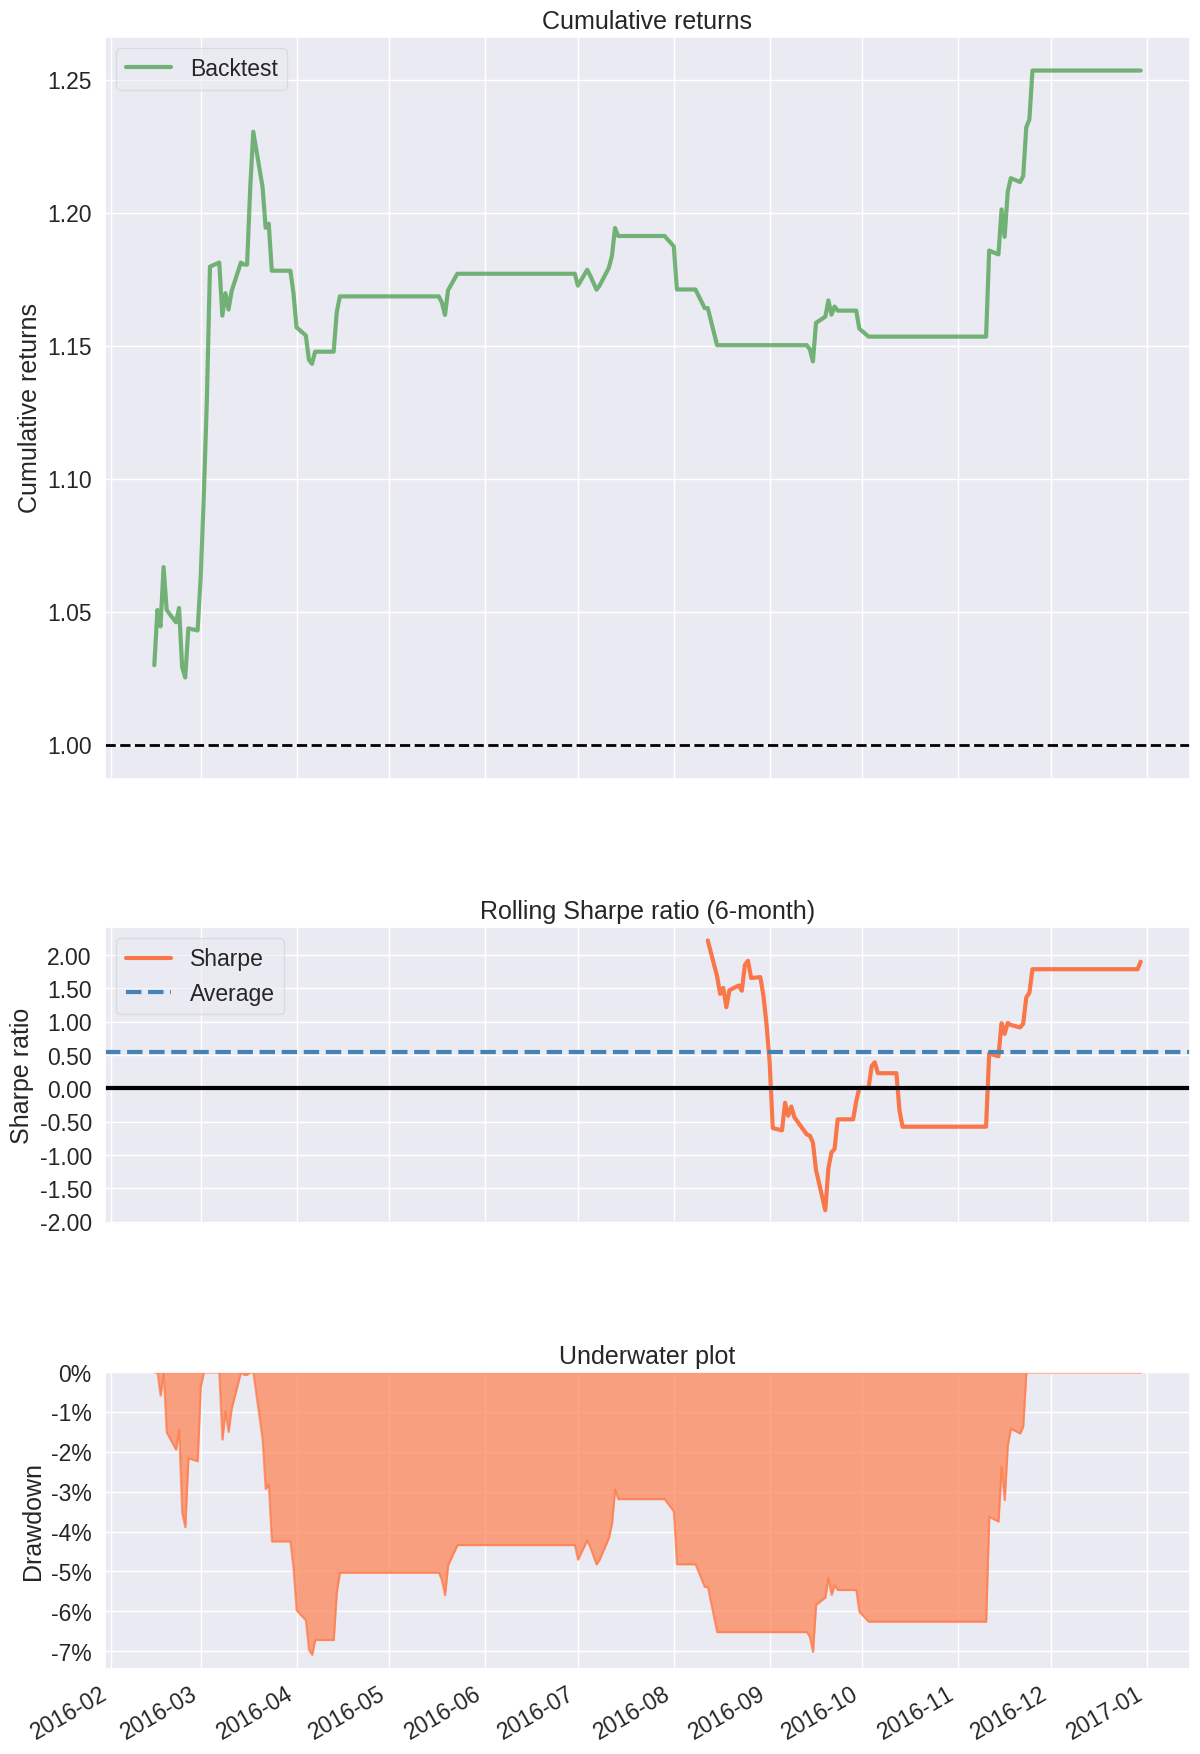

In [29]:
pf.create_simple_tear_sheet(df['strategy_returns'])



---

#THE END



---

